# Chapter 7 - Distributional Q-learning

In [1]:
import numpy as np
probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]

print(expected_value)

18.4


In [2]:
expected_value = probs @ outcomes
print(expected_value)

18.4


In [3]:
t0 = 18.4
T = lambda: t0 + np.random.randn(1)
T()

array([18.39613106])

# Representing probability distribution 

##### Listing 7.1 - discrete probability distribution

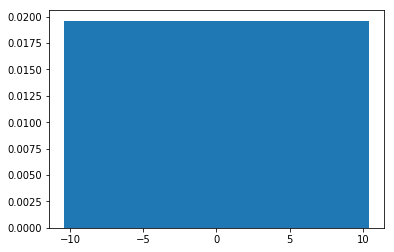

In [186]:
import torch
import numpy as np
from matplotlib import pyplot as plt

vmin,vmax = -10.,10. #1: minimum and maximum values of the support of the distribution
nsup=51 #2: the number of elements of the support
support = np.linspace(vmin,vmax,nsup) #3: support tensor; evenly spaced values from -10 to +10
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support,probs) #4: plotting
plt.show()

##### Listing 7.2 - updating a probability distribution

In [21]:
def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #1: calculates the support spacing value
    bj = np.round((r-vmin)/dz) #2: calculates the index value of the observed reward in the support
    bj = int(np.clip(bj,0,nsup-1)) #3: rounds and clips the value to make sure it is a valid index value for the support
    m = probs.clone()
    j = 1.0
    for i in range(bj,1,-1): #4: starting from the immediate left neighbor, steals part of its probability
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #5:starting from the immediate right neighbor, steals part of its probability
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #6: divides by the sum to make sure it sums to 1
    return m

In [188]:
probs

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

<BarContainer object of 51 artists>

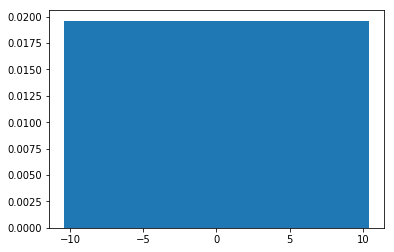

In [189]:
plt.bar(support, probs)

##### Listing 7.3 - redistributing probability mass after a single obserevation

<BarContainer object of 51 artists>

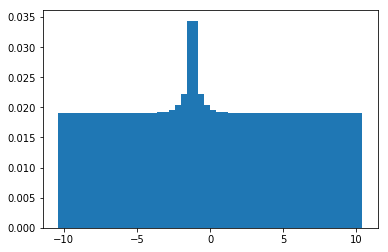

In [190]:
ob_reward = -1
Z = torch.from_numpy(probs)
Z = update_dist(ob_reward, torch.from_numpy(support), Z, lim=(vmin,vmax), gamma=0.4) # bigger gamma -> bigger `bump`
plt.bar(support, Z)

##### Listing 7.4 - redistributing probability mass with a sequence of observations

<BarContainer object of 51 artists>

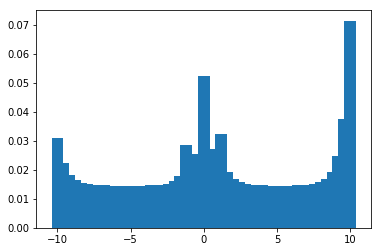

In [9]:
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10] # example reward values; peaks correspond to the four types of observed reward values
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin,vmax), gamma=0.5)
plt.bar(support, Z)

##### Listing 7.5 - decreased variance with sequence of same reward

<BarContainer object of 51 artists>

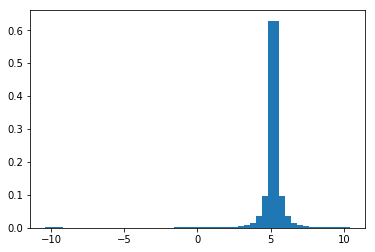

In [10]:
ob_rewards = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5] # variance decreases as using same rewards multiple times
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), \
    Z, lim=(vmin,vmax), gamma=0.7)
plt.bar(support, Z)

# Dist-DQN 

##### Listing 7.6 - the dist-DQN

In [9]:
def dist_dqn(x,theta,aspace=3): #1: x: 128-element vector state; theta: parameter; aspace: the size of the action space
    dim0,dim1,dim2,dim3 = 128,100,25,51 #2: the layer dimensions
    t1 = dim0*dim1
    t2 = dim2*dim1
    theta1 = theta[0:t1].reshape(dim0,dim1) #3: unpacks the first proportion of theta into the first layer matrix
    theta2 = theta[t1:t1 + t2].reshape(dim1,dim2)
    l1 = x @ theta1 #4: Bx128 @ 128x100 = Bx100 (B: batch size)
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 #5: Bx100 @ 100x25 = Bx25
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace): #6: loops through each action to generate each action-value distribution
        step = dim2*dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2,dim3)
        l3_ = l2 @ theta5 #7: Bx25 @ 25x51 = Bx51
        l3.append(l3_)
    l3 = torch.stack(l3,dim=1) #8: Bx3x51
    l3 = torch.nn.functional.softmax(l3,dim=2)
    return l3.squeeze()

##### Listing 7.5 - computing the tagetdistribtion

In [10]:
def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #1: loops through the batch dimension
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #2: if the reward is not 01 -> terminal state; the target is a degenerate distribution at the reward value
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: #3: if the state is non-terminal -> the target distribution is a Bayesian update of the prior given the reward
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #4: only changes the distribution for the action that was taken
        
    return target_dist_batch

##### Listing 7.8 - using cross-entropy as a loss function

In [11]:
def lossfn(x,y):#1: using cross-entropy to measure loss between prediction distribution(x) and target distribution(y)
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #2: loops through batch dimension
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) #3: flattens along action dimension to get a concatenated sequence of the distributions
        loss = loss + loss_
    return loss

##### Listing 7.9

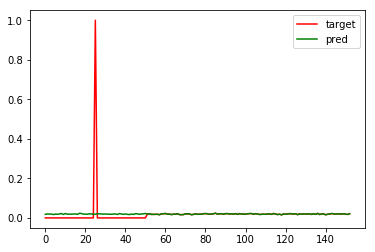

In [12]:
aspace = 3 #1: defines the action space (=3)
tot_params = 128*100 + 25*100 + aspace*25*51 #2: the total number of Dist-DQN parameters (=layer sizes)
theta = torch.randn(tot_params)/10. #3: randomly initializes a parameter vector for Dist-DQN
theta.requires_grad=True
theta_2 = theta.detach().clone() #4: clones theta to use as a target network

vmin,vmax= -10,10
gamma=0.9
lr = 0.00001
update_rate = 75 #5: synchronizes the main and target Dist-DQN parameters every 75 steps
support = torch.linspace(-10,10,51)
state = torch.randn(2,128)/10. #6: Randomly initializes two states for testing
action_batch = torch.Tensor([0,2]) #7: creates synthetic action data
reward_batch = torch.Tensor([0,10]) #8: creates synthetic rewrad data
losses = [] 
pred_batch = dist_dqn(state,theta,aspace=aspace) #9: initializes a prediction batch
target_dist = get_target_dist(pred_batch,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma) #10: initializes a target batch

plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.legend()

In [13]:
(pred_batch,action_batch,reward_batch, support, (vmin,vmax), gamma)

(tensor([[[0.0181, 0.0201, 0.0194, 0.0195, 0.0171, 0.0193, 0.0184, 0.0198,
           0.0226, 0.0174, 0.0222, 0.0191, 0.0190, 0.0192, 0.0197, 0.0202,
           0.0180, 0.0232, 0.0223, 0.0195, 0.0192, 0.0187, 0.0209, 0.0204,
           0.0186, 0.0189, 0.0211, 0.0203, 0.0200, 0.0195, 0.0197, 0.0190,
           0.0188, 0.0183, 0.0194, 0.0204, 0.0175, 0.0219, 0.0197, 0.0180,
           0.0200, 0.0181, 0.0170, 0.0194, 0.0177, 0.0212, 0.0209, 0.0180,
           0.0201, 0.0206, 0.0226],
          [0.0198, 0.0212, 0.0177, 0.0181, 0.0180, 0.0184, 0.0162, 0.0207,
           0.0210, 0.0225, 0.0192, 0.0193, 0.0170, 0.0188, 0.0186, 0.0213,
           0.0169, 0.0164, 0.0170, 0.0208, 0.0203, 0.0207, 0.0160, 0.0179,
           0.0207, 0.0182, 0.0191, 0.0186, 0.0211, 0.0222, 0.0203, 0.0188,
           0.0197, 0.0209, 0.0239, 0.0187, 0.0208, 0.0211, 0.0186, 0.0217,
           0.0216, 0.0198, 0.0210, 0.0190, 0.0219, 0.0181, 0.0215, 0.0200,
           0.0196, 0.0185, 0.0211],
          [0.0216, 0.0221, 0

##### Listing 7.10 - Dist-DQN training on synthetic data

In [14]:
for i in range(1000):
    reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0 #1: Adds some random noise to the rewards to mitigate overfitting
    pred_batch = dist_dqn(state,theta,aspace=aspace) #2: uses the main model Dist-DQN to make distribution predictions
    pred_batch2 = dist_dqn(state,theta_2,aspace=aspace) #3: uses the target network Dist-DQN to make distribution predictions (using lagged parameters)
    target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma) #4: uses the target network's distributions to create the target distribution for learning
    loss = lossfn(pred_batch,target_dist.detach()) #5: uses the main model's distribution prediction in the loss function
    losses.append(loss.item())
    loss.backward()
    # Gradient Descent
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    if i % update_rate == 0: #6: synchronizes the target network parameters with the main model parameters
        theta_2 = theta.detach().clone()

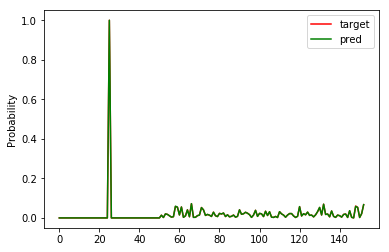

In [15]:
# The concatenated action-value distributions for all three actions after training 
plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.ylabel("Probability")
# plt.xlabel("No-OP               UP, DOWN")
plt.legend()

Text(0.5,0,'Epochs')

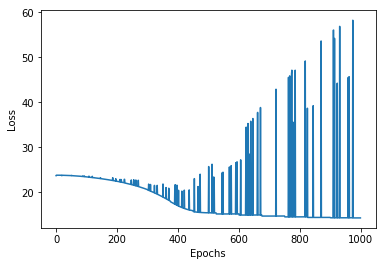

In [16]:
# Loss plot over time.
# The baseline loss is decreasing, but we see ever-increasing spikes.
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")

##### Listing 7.11 - visualizing the learned action-value distributions

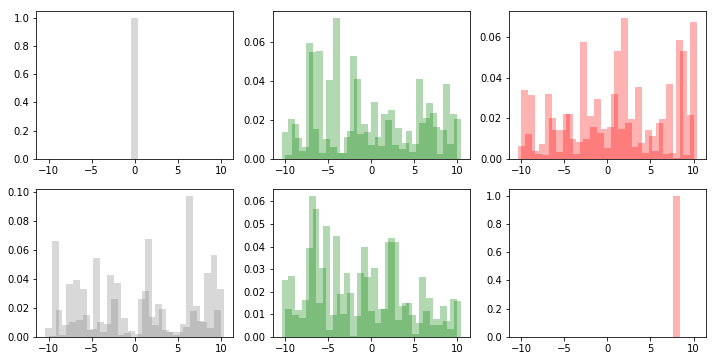

In [17]:
tpred = pred_batch
cs = ['gray','green','red']
num_batch = 2
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig,ax = plt.subplots(nrows=num_batch, ncols=aspace, figsize=(12, 6))

for j in range(num_batch): #1: loops through experiences in batch
    for i in range(tpred.shape[1]): #2: loops through each action
        ax[j,i].bar(support.data.numpy(), tpred[j,i,:].data.numpy(),
                    label='Action {}'.format(i),
                    alpha=0.3, color=cs[i])

##### Listing 7.12 - preprocessing states and selecting actions

In [18]:
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1) #1: normalizes state values to be between 0-1
    return p_state

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]): #2: loops through batch dimension of distribution
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #3: computes the expectation values for each action-value distribution
        action = int(np.argmax(expectations)) #4: computs the action associated with the highest expectation value
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

##### Listing 7.13 - Dist-DQN plays Freeway, preliminaries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
from collections import deque
env = gym.make("Freeway-ram-v0")
aspace = 3
env.env.get_action_meanings()

vmin, vmax = -10, 10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup - 1)
# support = torch.linspace(vmin, vmax, nsup)
support = np.linspace(vmin, vmax, nsup)
support = torch.from_numpy(support)


replay = deque(maxlen=replay_size) #1: experience replay buffer using the deque data structure
lr = 0.0001 #2: learning rate
gamma = 0.1 #3: discount factor
epochs = 1300 #4: starting epsilon for epsilon-greedy policy
eps = 0.20 #5: ending/minimum epsilon
eps_min = 0.05 
priority_level = 5 # prioritized-replay; duplicates highly informative experiences in the replay this many times
update_freq = 25 # 6: updates the target network every 25 times

#Initialize DQN parameter vector
tot_params = 128*100 + 25*100 + aspace*25*51  #7: the total number of parameters for Dist-DQN
theta = torch.randn(tot_params)/10.  #8: randomly initilaizes parameters for Dist-DQN
theta.requires_grad = True
theta_2 = theta.detach().clone()  #9: initializes parameters for target network
losses = []
cum_rewards = []
renders = []
state = preproc_state(env.reset())

##### Listing 7.14 - the main training loop

In [23]:
from random import shuffle
for i in range(epochs):
    pred = dist_dqn(state, theta, aspace=aspace)
    if (i < replay_size) or (np.random.rand(1) < eps):  # 1: epsilon-greedy action selectoin
        action = np.random.randint(aspace)
    else: 
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    
    state2, reward, done, info = env.step(action)  #2: takes selected action in the environment
    state2 = preproc_state(state2)
    
    if reward == 1:
        cum_rewards.append(1)
    reward = 10  if reward == 1 else reward  # 3: changes reward to +10 if environment produced reward of 1 (successful freeway crossing)
    reward = -10 if done else reward  # 4: changes reward to -10 if game is over (no crossings after a long time)
    reward = -1 if reward == 0 else reward # 5: changes reward to -1 if original reward was 0 (game is just continuiung); to penalize doing nothing
    exp = (state, action, reward, state2)  # 6: prepares experience as a tuple of the starting state, the observed reward, the action taken, and the subsequent state
    replay.append(exp) # adds experience to replay memory
    
    if reward == 10:  # 7: if reward is 10 -> indicates a successful crossing -> amplify this experience!
        for e in range(priority_level):
            replay.append(exp)
    
    shuffle(replay)
    state = state2
    
    if len(replay) == replay_size:  # 8: once replay buffer is full -> begins training
        indx = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps], dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps], dim=1).squeeze()
        pred_batch  = dist_dqn(state_batch.detach(),  theta,   aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(), theta_2, aspace=aspace)
        target_dist = get_target_dist(pred2_batch, action_batch, reward_batch, 
                                      support, lim=(vmin, vmax), gamma=gamma)
        loss = lossfn(pred_batch, target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        
        with torch.no_grad():  # 9: gradient descent
            theta -= lr * theta.grad
        theta.requires_grad = True
        
        if i % update_freq == 0:  #10: synchronizes the target network parameters to the main model parameters
            theta_2 = theta.detach().clone()
            
        if (i > 100) and (eps > eps_min):  # decrements epsilon as a function of the epoch number
            dec = 1./np.log2(i)
            dec /= 1e3
            eps -= dec
            
        if done: 
            state = preproc_state(env.reset())
            done = False
    
    

RuntimeError: Expected object of type torch.FloatTensor but found type torch.DoubleTensor for argument #4 'other'

In [ ]:
plt.plot(losses)